# <b>U-Net Model for Semantic Segmentation on Nuclei Dataset

In [1]:
# Importing usefull libraries
import numpy as np
import keras as k
import os
import random
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as cm,accuracy_score as acc

In [2]:
seed = 100
np.random.seed = seed

# Setting Input Image Size 
img_width = 128
img_height = 128
img_channels = 3

# Preprocessing the dataset and making it fit to the model

In [3]:
train_path = 'Dataset/train/'
test_path = 'Dataset/test/'

train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]

# Creating empty images and masks
x_train = np.zeros((len(train_ids),img_height,img_width,img_channels),dtype=np.uint8)
y_train = np.zeros((len(train_ids),img_height,img_width,1),dtype=np.bool)

# Resizing train images and creating their single mask 
In the dataset, each neulcei in the image has different mask respectively. Rather we want a single mask for single image
To do this, we will create a single mask for particular image and we will add all the masks into this single one.
We, will simply compare every mask with this single mask pixel wise, and we will update the single mask with 
maximum(pixel in empty mask, pixel in every mask). This will give us the mask with all the nucleis in it.

In [4]:
print("Resizing training images and masks")
for n,Id in tqdm(enumerate(train_ids),total=len(train_ids)): # tqdm will show a percentage bar with the help of which we can see
    path = train_path + Id                                   # how many iterations have been completed
    img = imread(path + '/images/' + Id + '.png')[:,:,:img_channels] # Reading the particular image
    img = resize(img,(img_height,img_width),mode='constant',preserve_range='True') # Resizing image
    x_train[n] = img # Filling empty x_train with values from img
    mask = np.zeros((img_height,img_width,1),dtype=np.bool) # Creating an empty single mask.
    for mask_id in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_id) # Reading the particular mask
        mask_ = np.expand_dims(resize(mask_,(img_height,img_width),mode='constant',preserve_range='True'),axis=-1) # Resizing mask
        mask = np.maximum(mask,mask_) # Will store the maximum pixel in the mask 
    y_train[n] = mask
# Now we have images and their respective single mask.

  0%|          | 0/670 [00:00<?, ?it/s]

Resizing training images and masks


100%|██████████| 670/670 [09:17<00:00,  1.20it/s]


# Resizing test images

In [5]:
print('Resizing test images') 
x_test = np.zeros((len(test_ids),img_height,img_width,img_channels),dtype=np.uint8)
sizes_test = []
for n, Id in tqdm(enumerate(test_ids),total=len(test_ids)):
    path = test_path + Id
    img = imread(path + '/images/' + Id + '.png')[:,:,:img_channels]
#     sizes_test.append([img.shape[0], img.shape[1]])s
    img = resize(img,(img_height,img_width),mode='constant',preserve_range=True)
    x_test[n] = img

  3%|▎         | 2/65 [00:00<00:03, 17.12it/s]

Resizing test images


100%|██████████| 65/65 [00:01<00:00, 45.87it/s]


In [6]:
# Check if what we have done is worth or not 
# image_x = random.randint(0,len(train_ids))
# imshow(x_train[image_x])
# plt.show()
# imshow(np.squeeze(y_train[image_x]))
# plt.show()

# Building the U-Net model

In [7]:
# Input Layer
inputs = k.layers.Input((img_width,img_height,img_channels))

''' Since, layers only take floating point values, therefore we need to convert the pixel values of input from
    8bit int to floating point.
    The best way to do that is divide every pixel value by 255, since pixel values have the range 0-255.
    Therefore, dividing every value by 255 will convert it to a floating point'''
input_layer = k.layers.Lambda(lambda x: x/255)(inputs)

In [8]:
################## ENCODER / CONTRACTION ###########################

# 2 @ Convolutional Layers with 16 @ (3,3) filters and padding = same
c1 = k.layers.Conv2D(16,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(input_layer)
c1 = k.layers.Dropout(0.1)(c1)
c1 = k.layers.Conv2D(16,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(c1)
# Max Pooling with (2,2) filter and stride = 2
p1 = k.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(c1)

# 2 @ Convolutional Layers with 32 @ (3,3) filters and padding = same
c2 = k.layers.Conv2D(32,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(p1)
c2 = k.layers.Dropout(0.1)(c2)
c2 = k.layers.Conv2D(32,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(c2)
# Max Pooling with (2,2) filter and stride = 2
p2 = k.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(c2)

# 2 @ Convolutional Layers with 64 @ (3,3) filters and padding = same
c3 = k.layers.Conv2D(64,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(p2)
c3 = k.layers.Dropout(0.2)(c3)
c3 = k.layers.Conv2D(64,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(c3)
# Max Pooling with (2,2) filter and stride = 2
p3 = k.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(c3)

# 2 @ Convolutional Layers with 128 @ (3,3) filters and padding = same
c4 = k.layers.Conv2D(128,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(p3)
c4 = k.layers.Dropout(0.2)(c4)
c4 = k.layers.Conv2D(128,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(c4)
# Max Pooling with (2,2) filter and stride = 2
p4 = k.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(c4)

# 2 @ Convolutional Layers with 256 @ (3,3) filters and padding = same
c5 = k.layers.Conv2D(256,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(p4)
c5 = k.layers.Dropout(0.3)(c5)
c5 = k.layers.Conv2D(256,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(c5)

################## DECODER / EXPANSION ###########################

# Up-Sampling with 128 @ (3,3) filters and padding = same and stride = 2
u6 = k.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
''' Adding a skip connection, which skip some layer in the neural network and feeds the output of one layer 
    as the input to the next layers (instead of only the next one). skip connections are used to skip features 
    from the contracting path to the expanding path in order to recover spatial information lost during 
    downsampling.'''
u6 = k.layers.concatenate([u6,c4])
# 2 @ Convolutional Layers with 128 @ (3,3) filters and padding = same
c6 = k.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6 = k.layers.Dropout(0.2)(c6)
c6 = k.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

# Up-Sampling with 64 @ (3,3) filters and padding = same and stride = 2
u7 = k.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
u7 = k.layers.concatenate([u7,c3])
# 2 @ Convolutional Layers with 64 @ (3,3) filters and padding = same
c7 = k.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7 = k.layers.Dropout(0.2)(c7)
c7 = k.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

# Up-Sampling with 32 @ (3,3) filters and padding = same and stride = 2
u8 = k.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8 = k.layers.concatenate([u8,c2])
# 2 @ Convolutional Layers with 32 @ (3,3) filters and padding = same
c8 = k.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8 = k.layers.Dropout(0.2)(c8)
c8 = k.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

# Up-Sampling with 16 @ (3,3) filters and padding = same and stride = 2
u9 = k.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9 = k.layers.concatenate([u9,c1])
# 2 @ Convolutional Layers with 16 @ (3,3) filters and padding = same
c9 = k.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9 = k.layers.Dropout(0.2)(c9)
c9 = k.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

#Final Output with 1 @ Convolutional Layer and 1 @ (1,1) filter
outputs = k.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)

model = k.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

# Understanding some important arguments
batch_size -> If you want your data to be divided in batches. (Total no. of training examples present in a single batch)
epoch -> One epoch is when an entire dataset is passed forward and backward through the neural network only once.
verbose -> Accepts value 0/1. Set verbose = 1 if you want to see anything on the screen after one epoch.
validation_split -> What percentage of data you want to keep aside for validation purposes.

# Callbacks:
    1) ModelCheckpoint -> With this, we can check our model over a period of time. It basically save the model after every epoch.
                    Basically, if something stopped unexpectedly, you dont wanna loose something. This is where it helps.
    Arguments -> 
        filepath -> path to save the model file
        save_best_only -> It saves the recent best model.
    2) EarlyStopping -> If you put too many epochs, you are probably overfitting. If you put too less epochs, you are probably
                        underfitting the data. How many epochs to put we really dont know, this is where EarlyStopping is usefull.
    Arguments ->
        monitor -> Which factor you want to monitor. Example: val_loss -> If there is no improvement in validation loss, then stop 
                    the training.
        patience -> How do we know that if there is improvement or not. This is where patience helps, eg: for monitor='val_loss' and
                    patience=3 means EarlyStopping will stop the training if there is no improvement in the validation loss for three
                    consecutive epochs.
    3) tensorboard -> it is a visualisation tool provided by tensorflow
    Arguments ->
        log_dir -> the path of the directory where to save the log files to be parsed by tensorflow.

In [9]:
# Model Checkpoint
checkpointer = k.callbacks.ModelCheckpoint('model_for_nuclei.h5',verbose=1,save_best_only=True)

callbacks = [
        k.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        k.callbacks.TensorBoard(log_dir='logs')]

# Training the model 

In [10]:
results = model.fit(x_train,y_train,validation_split=0.1,batch_size=16,epochs=25,callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 136s 3s/step - loss: 0.5910 - accuracy: 0.7809 - val_loss: 0.4156 - val_accuracy: 0.8346
Epoch 2/25
38/38 [==============================] - 110s 3s/step - loss: 0.3007 - accuracy: 0.8291 - val_loss: 0.2158 - val_accuracy: 0.9145
Epoch 3/25
38/38 [==============================] - 108s 3s/step - loss: 0.1835 - accuracy: 0.9328 - val_loss: 0.1443 - val_accuracy: 0.9426
Epoch 4/25
38/38 [==============================] - 109s 3s/step - loss: 0.1380 - accuracy: 0.9476 - val_loss: 0.1319 - val_accuracy: 0.9510
Epoch 5/25
38/38 [==============================] - 112s 3s/step - loss: 0.1289 - accuracy: 0.9502 - val_loss: 0.1105 - val_accuracy: 0.9579
Epoch 6/25
38/38 [==============================] - 110s 3s/step - loss: 0.1111 - accuracy: 0.9571 - val_loss: 0.1089 - val_accuracy: 0.9585
Epoch 7/25
38/38 [==============================] - 112s 3s/step - loss: 0.1169 - accuracy: 0.9557 - val_loss: 0.0972 - val_accuracy: 0.9632
Epoch 8/25
38

# Predictions

In [11]:
'''
x_train.shape = [670 128 128 3]
x_train.shape[0] = 670
0.1 was our validation_split which means, data for validation 0.1*670 = 67 and data for training 0.9*670 = 603
x_train[:603] -> Dataset for training
x_train[603:] -> Dataset for validation
'''
pred_train = model.predict(x_train[:int(x_train.shape[0]*0.9)],verbose=1)
pred_val = model.predict(x_train[int(x_train.shape[0]*0.9):],verbose=1)
pred_test = model.predict(x_test,verbose=1)
'''
Since predictions will range from -infinity to +infinity but we need to have boolean predictions
(pred_train > 0.5) will result into True/False and .astype(np.uint8) will convert True/False to 1/0.
''' 
train_predictions = (pred_train > 0.5).astype(np.uint8)
val_predictions = (pred_val > 0.5).astype(np.uint8)
test_predictions = (pred_test > 0.5).astype(np.uint8)

3/3 [==============================] - 2s 603ms/step


# Sanity Checks

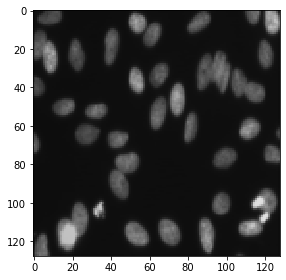

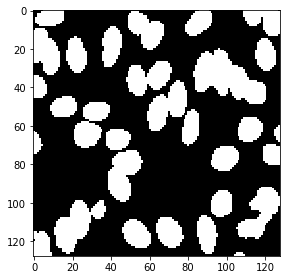

/home/geekunny/anaconda3/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


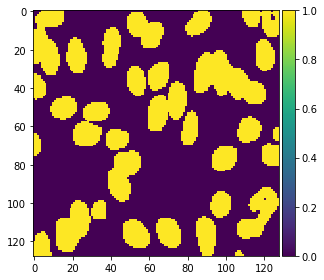

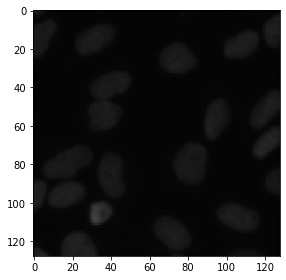

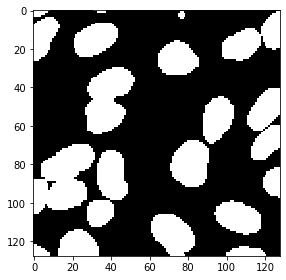

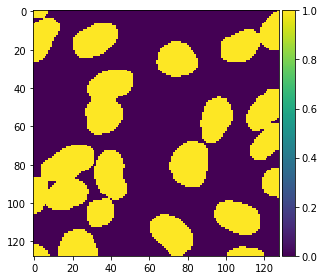

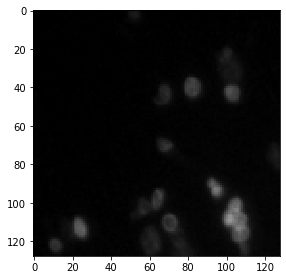

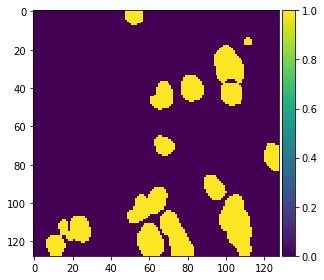

In [12]:
# Performing a sanity check on some random training samples
ix = random.randint(0,len(train_predictions))
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(train_predictions[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0,len(val_predictions))
imshow(x_train[int(x_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(val_predictions[ix]))
plt.show()

# Predicting the image on some random test samples
ix = random.randint(0,len(test_predictions))
imshow(x_test[ix])
plt.show()
imshow(np.squeeze(test_predictions[ix]))
plt.show()

# Finding Intersection on Union (IoU)
IoU is used as a evalutation technique for Image Segmentation Models.

In [13]:
y_true = np.squeeze(y_train[:int(y_train.shape[0]*0.9)].astype(np.uint8))
pred = np.squeeze(train_predictions)
IoU = k.metrics.MeanIoU(num_classes = 2)
IoU.update_state(y_true,pred)
m_IoU = IoU.result().numpy()*100
print("Mean IoU: %.2f"%m_IoU + ' %')

Mean IoU: 90.99 %


<B> HURRAYYYY!! You have successfully implemented U-Net Model for Semantic Segmentation on Nuclei Dataset.